In [1]:
import gc
from itertools import product
import re

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

In [2]:
d = {'EI': 0, 'IE': 1, 'N': 2}

def load_splice(file):
    with open(file) as f:
        l = []
        for record in f:
            record = re.split(',\\s+', record.strip())
            record[2] = record[2].replace('N','A').replace('D','G').replace('S','C').replace('R','G')
            l.append(record)

    x = [list(line[2]) for line in l]
    y = list(map(lambda y: d[y], (line[0] for line in l)))
    return x, y

x, y = load_splice('../data/splice/splice.data')

# features: 60 bp


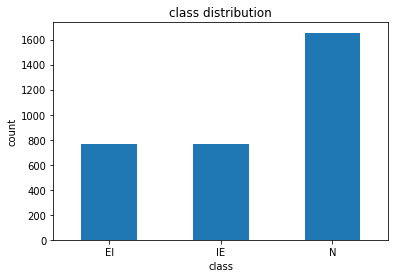

In [3]:
ax = pd.Series(y).value_counts().sort_index().plot(kind='bar')
ax.set_title('class distribution')
ax.set_xlabel('class')
ax.set_ylabel('count')
ax.set_xticklabels(d.keys())
ax.tick_params(rotation=0)

print('# features:', len(x[0]), 'bp')

In [4]:
word_size = 3

words = [''.join(p) for p in product('ACGT', repeat=word_size)]
word_to_idx = {word: i for i, word in enumerate(words)}
vocab_size = len(word_to_idx)

print('vocab_size:', vocab_size)

vocab_size: 64


In [5]:
# transform word array into index array
word_to_idx_func = np.vectorize(lambda word: word_to_idx[word], otypes=[np.int8])

def x_to_encoding(x, word_size=3, region_size=2, expand=True):
    '''transform index array into one-hot encoded array'''
    # word to index
    words_ = tf.strings.ngrams(x, ngram_width=word_size, separator='').numpy()
    idx = word_to_idx_func(words_.astype('U'))
    # one-hot encode
    encoding = np.zeros((len(idx), len(word_to_idx)))
    encoding[range(len(idx)), idx] = 1
    # concat
    result = np.hstack([np.roll(encoding, -shift, axis=0)
                        for shift in range(region_size + 1)])
    if expand:
        return np.expand_dims(result, axis=-1)
    else:
        return result

# Conv2d

In [6]:
region_size = 0

x_ = np.apply_along_axis(x_to_encoding, 1, x, region_size=region_size)
y_ = pd.get_dummies(y).to_numpy(dtype='float32')

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_, y_, stratify=y)
len(x_train), len(x_test)

(2392, 798)

In [8]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(54, 3, activation='relu', input_shape=x_train.shape[1:]),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax'),
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 62, 54)        540       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 31, 54)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 31, 54)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46872)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5999744   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [9]:
history = model.fit(x_train, y_train, epochs=15, validation_split=0.15, verbose=2)

Epoch 1/15
64/64 - 5s - loss: 0.3412 - accuracy: 0.8578 - val_loss: 0.2007 - val_accuracy: 0.9220
Epoch 2/15
64/64 - 7s - loss: 0.1076 - accuracy: 0.9680 - val_loss: 0.1441 - val_accuracy: 0.9582
Epoch 3/15
64/64 - 5s - loss: 0.0530 - accuracy: 0.9843 - val_loss: 0.1459 - val_accuracy: 0.9499
Epoch 4/15
64/64 - 4s - loss: 0.0310 - accuracy: 0.9897 - val_loss: 0.2264 - val_accuracy: 0.9331
Epoch 5/15
64/64 - 5s - loss: 0.0183 - accuracy: 0.9941 - val_loss: 0.1911 - val_accuracy: 0.9359
Epoch 6/15
64/64 - 4s - loss: 0.0146 - accuracy: 0.9956 - val_loss: 0.2794 - val_accuracy: 0.9304
Epoch 7/15
64/64 - 4s - loss: 0.0129 - accuracy: 0.9961 - val_loss: 0.2708 - val_accuracy: 0.9331
Epoch 8/15
64/64 - 4s - loss: 0.0121 - accuracy: 0.9970 - val_loss: 0.2606 - val_accuracy: 0.9387
Epoch 9/15
64/64 - 4s - loss: 0.0081 - accuracy: 0.9990 - val_loss: 0.2415 - val_accuracy: 0.9443
Epoch 10/15
64/64 - 4s - loss: 0.0140 - accuracy: 0.9956 - val_loss: 0.2393 - val_accuracy: 0.9443
Epoch 11/15
64/64 -

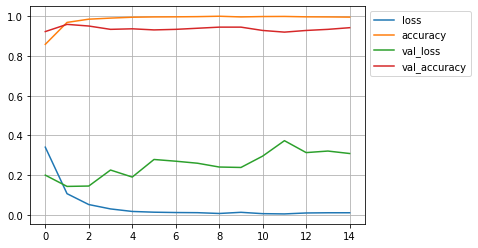

In [10]:
ax = pd.DataFrame(history.history).plot()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.grid()

In [11]:
model.evaluate(x_test, y_test, verbose=2)

25/25 - 0s - loss: 0.2910 - accuracy: 0.9486


[0.2910248041152954, 0.9486215710639954]

In [12]:
gc.collect()

5423

# Conv1d

In [13]:
region_size = 0

x_ = np.apply_along_axis(x_to_encoding, 1, x, region_size=region_size, expand=False)
y_ = pd.get_dummies(y).to_numpy(dtype='float32')

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_, y_, stratify=y)
len(x_train), len(x_test)

(2392, 798)

In [15]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv1D(54, 3, activation='relu', input_shape=x_train.shape[1:]),
    keras.layers.MaxPooling1D(),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax'),
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 56, 54)            10422     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 28, 54)            0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 54)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1512)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               193664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [16]:
history = model.fit(x_train, y_train, epochs=15, validation_split=0.15, verbose=2)

Epoch 1/15
64/64 - 1s - loss: 0.8382 - accuracy: 0.6296 - val_loss: 0.4323 - val_accuracy: 0.9192
Epoch 2/15
64/64 - 0s - loss: 0.2827 - accuracy: 0.9198 - val_loss: 0.1318 - val_accuracy: 0.9638
Epoch 3/15
64/64 - 0s - loss: 0.1437 - accuracy: 0.9523 - val_loss: 0.0858 - val_accuracy: 0.9721
Epoch 4/15
64/64 - 0s - loss: 0.0985 - accuracy: 0.9734 - val_loss: 0.0853 - val_accuracy: 0.9694
Epoch 5/15
64/64 - 0s - loss: 0.0878 - accuracy: 0.9710 - val_loss: 0.1016 - val_accuracy: 0.9694
Epoch 6/15
64/64 - 1s - loss: 0.0658 - accuracy: 0.9818 - val_loss: 0.0916 - val_accuracy: 0.9694
Epoch 7/15
64/64 - 1s - loss: 0.0416 - accuracy: 0.9872 - val_loss: 0.0776 - val_accuracy: 0.9666
Epoch 8/15
64/64 - 1s - loss: 0.0334 - accuracy: 0.9916 - val_loss: 0.0777 - val_accuracy: 0.9749
Epoch 9/15
64/64 - 1s - loss: 0.0244 - accuracy: 0.9961 - val_loss: 0.0750 - val_accuracy: 0.9694
Epoch 10/15
64/64 - 1s - loss: 0.0165 - accuracy: 0.9961 - val_loss: 0.0719 - val_accuracy: 0.9721
Epoch 11/15
64/64 -

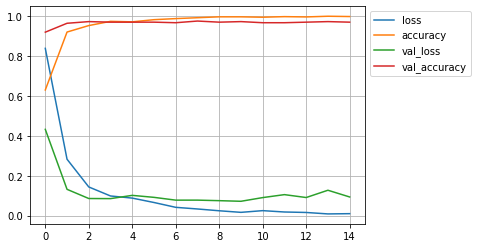

In [17]:
ax = pd.DataFrame(history.history).plot()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.grid()

In [18]:
model.evaluate(x_test, y_test, verbose=2)

25/25 - 0s - loss: 0.1471 - accuracy: 0.9712


[0.14707927405834198, 0.9711779356002808]

In [19]:
gc.collect()

8508